In [1]:
# Preprocessing Code
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

def preprocess(df: pd.DataFrame, is_train=True, ordinal_encoder=None, cat_cols=None):
    """Preprocess the dataset using OrdinalEncoder and feature engineering."""

    # Define columns where NaN means 'None' or 0
    none_cols = [
        'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
        'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Electrical'
    ]
    zero_cols = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath',
                 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

    for col in none_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None')
    for col in zero_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Binary flags
    df['HasPool'] = (df['PoolQC'] != 'None').astype(int)
    df['HasGarage'] = (df['GarageType'] != 'None').astype(int)
    df['HasBasement'] = (df['BsmtQual'] != 'None').astype(int)
    df['HasFireplace'] = (df['FireplaceQu'] != 'None').astype(int)
    df['HasFence'] = (df['Fence'] != 'None').astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)

    # Impute LotFrontage by Neighborhood median
    if 'LotFrontage' in df.columns and 'Neighborhood' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median())
        )

    # Feature Engineering
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (
        df['FullBath'] + 0.5 * df['HalfBath'] +
        df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    )
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)

    # Log transformations
    for col in ['GrLivArea', 'LotArea', 'TotalSF']:
        if col in df.columns:
            df[col] = np.log1p(df[col])

    # Fill remaining numeric NaNs with -1 to mark them as missing
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(-1)

    # Encode categorical variables
    if is_train:
        cat_cols = df.select_dtypes(include=['object']).columns.tolist()
        df[cat_cols] = df[cat_cols].astype(str)

        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df[cat_cols] = encoder.fit_transform(df[cat_cols]).astype(np.float32)
        return df, encoder, cat_cols
    else:
        if cat_cols is None:
            cat_cols = ordinal_encoder.feature_names_in_.tolist()

        df[cat_cols] = df[cat_cols].astype(str)
        df[cat_cols] = ordinal_encoder.transform(df[cat_cols]).astype(np.float32)
        return df


# 🔬 Model Comparison & Submission – House Prices

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
import lightgbm as lgb
import xgboost as xgb
import joblib

# Load cleaned training and test data
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
import sys, os
sys.path.append(os.path.abspath('../src'))
from preprocess import preprocess

train, encoder, cat_cols = preprocess(train, is_train=True)
test = preprocess(test, is_train=False, ordinal_encoder=encoder, cat_cols=cat_cols)
print(test.dtypes[test.dtypes == 'object'])

X = train.drop("SalePrice", axis=1)
y = train["SalePrice"]
# Final alignment
X_test = test[X.columns]
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(-1).astype('float32')



MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

## 📊 Cross-Validation Comparison

In [4]:
# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    score = rmse_cv(model)
    results[name] = score
    print(f"{name}: RMSE = {score:.2f}")

Ridge: RMSE = 39870.61


/Users/maciejgieparda/KaggleProjects/KaggleHousePricesCompetition/kaggle-house-prices-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/maciejgieparda/KaggleProjects/KaggleHousePricesCompetition/kaggle-house-prices-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/maciejgieparda/KaggleProjects/KaggleHousePricesCompetition/kaggle-house-prices-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/maciejgieparda/KaggleProjects/KaggleHousePricesCompetition/kaggle-house-prices-env/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/maciejgieparda/KaggleProjects/KaggleHousePricesCompetition/kaggle-house-prices-env/lib/python3.10/site-packa

RandomForest: RMSE = 29533.70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3818
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 80
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3814
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 81
[LightGBM] [Info] Start training from score 179651.292808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove th

## 🏁 Train Final Model & Predict

## 📈 Model Performance Comparison

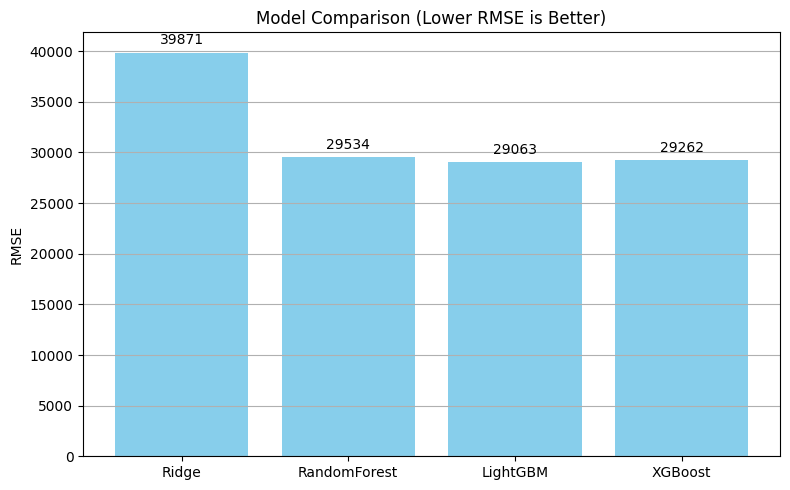

In [5]:
# Visualize model RMSE scores


model_names = list(results.keys())
rmse_scores = list(results.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, rmse_scores, color='skyblue')
plt.title('Model Comparison (Lower RMSE is Better)')
plt.ylabel('RMSE')
plt.grid(axis='y')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 500, f'{yval:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:


# Ustaw model bazowy
lgb_model = lgb.LGBMRegressor(random_state=42)


In [7]:
from tqdm import tqdm

class TQDMSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None, *, groups=None, **fit_params):
        self._n_candidates = self.n_iter
        with tqdm(total=self.n_iter, desc="Random Search Progress") as pbar:
            def callback(_, __, ___):
                pbar.update(1)
            old_verbose = self.verbose
            self.verbose = 0  # wyłącz domyślny spam
            result = super().fit(X, y, groups=groups, **fit_params, callback=callback)
            self.verbose = old_verbose
        return result

param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': randint(20, 64),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

rand_search = RandomizedSearchCV(  # ✅ Standard class works with parallel processing
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,        # ✅ Shows progress: "Fitting X folds for each of Y candidates"
    n_jobs=1,  # Fixed: Disable parallel processing to avoid pickling issues        # ✅ Parallel processing works fine
    random_state=42
)

# === Fit + wyniki ===
rand_search.fit(X, y)
print("\n✅ Best RMSE:", -rand_search.best_score_)
print("✅ Best parameters:")
print(rand_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3618
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 78
[LightGBM] [Info] Start training from score 179726.031860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [8]:
final_model = rand_search.best_estimator_
final_model.fit(X, y)
preds = final_model.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4084
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 81
[LightGBM] [Info] Start training from score 180921.195890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

## 💾 Save Submission

In [9]:
# Prepare submission file
submission = sample_submission.copy()
submission['SalePrice'] = preds
submission.to_csv('../data/submission.csv', index=False)
print('✅ Submission saved to ../data/submission.csv')

✅ Submission saved to ../data/submission.csv


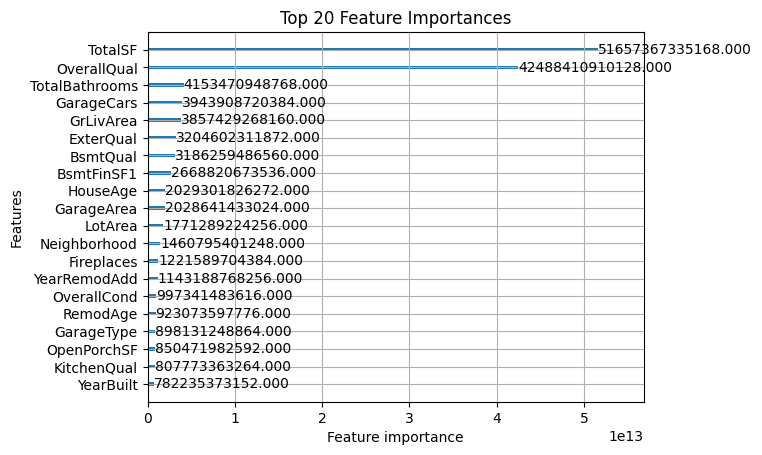

In [10]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(final_model.booster_, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


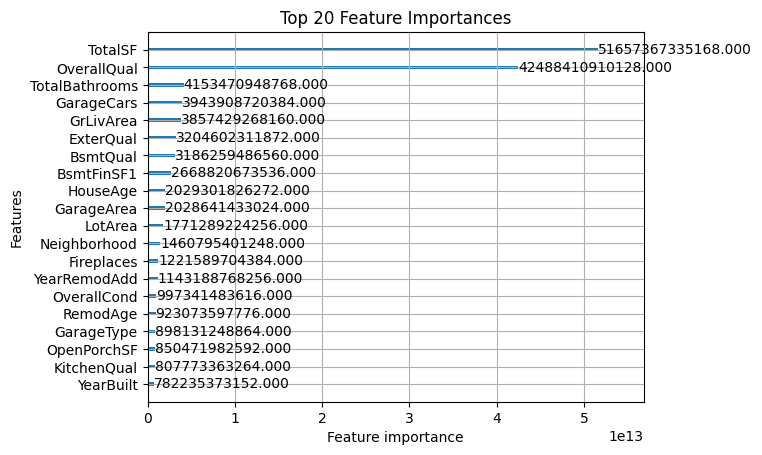

In [11]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(final_model.booster_, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


In [12]:
import shap


explainer = shap.TreeExplainer(final_model.booster_)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


ModuleNotFoundError: No module named 'shap'